In [1]:
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import implicit as imp

from scipy import sparse

In [2]:
# !pip install fastparquet
# !pip install pyarrow

In [3]:
TIMESPENT_COEF = 1
REACTION_COEF = 10

In [4]:
# train упорядочен хронологически
df = pd.read_parquet('train.parquet.gzip')
df.dtypes

user_id      int32
item_id      int32
timespent     int8
reaction      int8
dtype: object

# EDA

## Users

In [5]:
user_history_sizes = df.groupby('user_id').size()

In [6]:
user_history_sizes.describe().astype(int)

count    1000183
mean         144
std          124
min            6
25%           53
50%          104
75%          198
max         1018
dtype: int64

In [7]:
user_history_sizes.values

array([ 34,  79,  51, ...,  88,  37, 132])

(array([2.72093e+05, 2.42742e+05, 1.49815e+05, 1.02953e+05, 7.07460e+04,
        5.15500e+04, 3.68040e+04, 2.54430e+04, 1.85470e+04, 1.20090e+04,
        7.93200e+03, 4.58300e+03, 2.57300e+03, 1.39500e+03, 5.86000e+02,
        2.71000e+02, 9.10000e+01, 3.50000e+01, 1.30000e+01, 2.00000e+00]),
 array([   6. ,   56.6,  107.2,  157.8,  208.4,  259. ,  309.6,  360.2,
         410.8,  461.4,  512. ,  562.6,  613.2,  663.8,  714.4,  765. ,
         815.6,  866.2,  916.8,  967.4, 1018. ]),
 <a list of 20 Patch objects>)

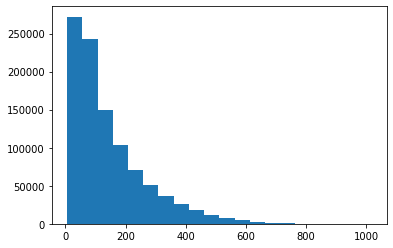

In [8]:
plt.hist(user_history_sizes.values, bins=20)

In [9]:
# экспоненциальное распределение историй юзеров

## Users-items

In [10]:
df.reaction.describe().apply(lambda x: '%.8f' % x)

count    144440015.00000000
mean             0.00868349
std              0.10022833
min             -1.00000000
25%              0.00000000
50%              0.00000000
75%              0.00000000
max              1.00000000
Name: reaction, dtype: object

In [11]:
len(df)

144440015

In [12]:
df.reaction.value_counts(1)

 0    0.989879
 1    0.009402
-1    0.000719
Name: reaction, dtype: float64

In [13]:
# реакций очень мало

In [14]:
df[df.timespent != 0].reaction.value_counts(1)

 0    0.951733
 1    0.046220
-1    0.002047
Name: reaction, dtype: float64

In [15]:
# однако, при каком-то потраченном времени, явных предпочтений больше

In [16]:
df[df.timespent > 20].reaction.value_counts(1)

 0    0.886713
 1    0.108765
-1    0.004522
Name: reaction, dtype: float64

In [17]:
# 20 минут и реакций в два раза больше

In [18]:
df.timespent.describe().apply(lambda x: '%.8f' % x)

count    144440015.00000000
mean             0.54465602
std              1.69075048
min              0.00000000
25%              0.00000000
50%              0.00000000
75%              0.00000000
max             60.00000000
Name: timespent, dtype: object

In [19]:
len(df[df.timespent == 0]) / len(df)

0.8367525093375268

In [20]:
# 84% взаимодействий имеют 0 минут

In [21]:
len(df[(df.timespent == 0) & (df.reaction != 0)]) / len(df[df.timespent == 0])

0.0026790380599392466

In [22]:
# всего 2% реакций при нулевом прочтение => более менее чисто => оценки сильно влияют

(array([4.00000e+00, 1.20000e+01, 3.00000e+01, 7.15000e+02, 9.70302e+05,
        1.90210e+04, 6.04800e+03, 2.55600e+03, 1.10600e+03, 3.89000e+02]),
 array([-0.77647059, -0.59882353, -0.42117647, -0.24352941, -0.06588235,
         0.11176471,  0.28941176,  0.46705882,  0.64470588,  0.82235294,
         1.        ]),
 <a list of 10 Patch objects>)

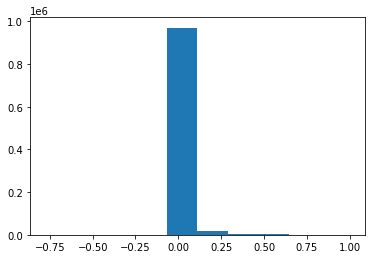

In [23]:
plt.hist(df.groupby('user_id').reaction.mean())

In [24]:
df.groupby('user_id').item_id.size()

user_id
0           34
1           79
2           51
3          242
4          139
          ... 
1000178     24
1000179     43
1000180     88
1000181     37
1000182    132
Name: item_id, Length: 1000183, dtype: int64

(array([1.27412286e+08, 9.07307100e+06, 4.20513600e+06, 1.91807800e+06,
        9.14276000e+05, 4.39455000e+05, 2.16062000e+05, 1.11024000e+05,
        5.96150000e+04, 3.41740000e+04, 2.00020000e+04, 1.22560000e+04,
        7.80400000e+03, 4.89100000e+03, 3.26700000e+03, 2.30400000e+03,
        1.64300000e+03, 1.17300000e+03, 8.26000000e+02, 6.50000000e+02,
        5.22000000e+02, 3.41000000e+02, 2.72000000e+02, 2.35000000e+02,
        1.98000000e+02, 1.32000000e+02, 8.60000000e+01, 8.90000000e+01,
        6.70000000e+01, 8.00000000e+01]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58., 60.]),
 <a list of 30 Patch objects>)

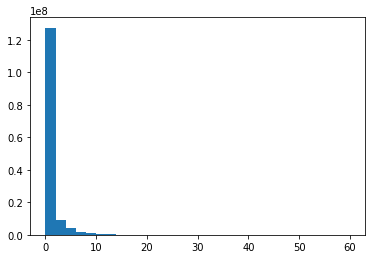

In [25]:
plt.hist(df.timespent, bins=30)

# Items

In [26]:
# в items_meta для каждого item_id его автор и эмбеддинг содержания
items = pd.read_parquet(f'items_meta.parquet.gzip')
items.head(3)

,item_id,source_id,embeddings
0,0,7340,"[0.10458118, 0.047880154, 0.030944156, -0.0351..."
1,1,6284,"[0.035625108, -0.039264094, -0.03310334, -0.04..."
2,2,12766,"[0.08418761, 0.006732465, -0.0037112322, -0.02..."


In [27]:
len(items)

227606

In [28]:
item_sizes = items.groupby('source_id').size()

(array([2.321e+04, 9.130e+02, 1.990e+02, 6.300e+01, 2.600e+01, 1.100e+01,
        5.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1. ,  37.6,  74.2, 110.8, 147.4, 184. , 220.6, 257.2, 293.8,
        330.4, 367. , 403.6, 440.2, 476.8, 513.4, 550. , 586.6, 623.2,
        659.8, 696.4, 733. ]),
 <a list of 20 Patch objects>)

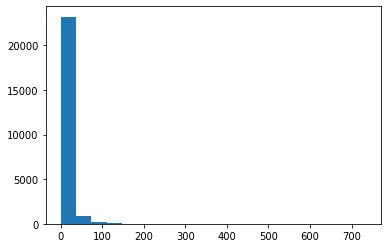

In [29]:
plt.hist(item_sizes, 20)

в основном непопулярные авторы

In [30]:
item_sizes.describe().astype(int)

count    24438
mean         9
std         18
min          1
25%          1
50%          3
75%         10
max        733
dtype: int64

In [31]:
len(df.item_id.unique() - items.item_id.unique())

227606

все итемы имеют хотя бы одного юзера

In [32]:
item_history_sizes = df.groupby('item_id').size()

(array([2.24248e+05, 2.34900e+03, 5.69000e+02, 2.20000e+02, 9.60000e+01,
        4.50000e+01, 2.50000e+01, 1.60000e+01, 9.00000e+00, 1.10000e+01,
        4.00000e+00, 6.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([3.0000000e+00, 6.1521500e+03, 1.2301300e+04, 1.8450450e+04,
        2.4599600e+04, 3.0748750e+04, 3.6897900e+04, 4.3047050e+04,
        4.9196200e+04, 5.5345350e+04, 6.1494500e+04, 6.7643650e+04,
        7.3792800e+04, 7.9941950e+04, 8.6091100e+04, 9.2240250e+04,
        9.8389400e+04, 1.0453855e+05, 1.1068770e+05, 1.1683685e+05,
        1.2298600e+05]),
 <a list of 20 Patch objects>)

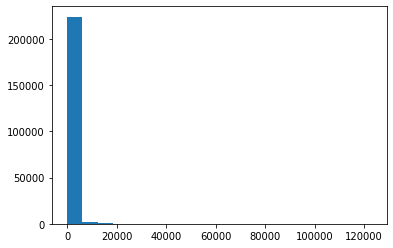

In [33]:
plt.hist(item_history_sizes, 20)

очевидно, есть топ популярных авторов

In [34]:
item_history_sizes.describe()

count    227606.000000
mean        634.605481
std        1959.061420
min           3.000000
25%          68.000000
50%         172.000000
75%         490.000000
max      122986.000000
dtype: float64

In [35]:
item_history_timespent = df.groupby('item_id').timespent.sum()

(array([2.26245e+05, 8.42000e+02, 2.56000e+02, 1.03000e+02, 5.90000e+01,
        3.20000e+01, 2.30000e+01, 1.70000e+01, 7.00000e+00, 6.00000e+00,
        3.00000e+00, 3.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([3.000000e+00, 7.893400e+03, 1.578380e+04, 2.367420e+04,
        3.156460e+04, 3.945500e+04, 4.734540e+04, 5.523580e+04,
        6.312620e+04, 7.101660e+04, 7.890700e+04, 8.679740e+04,
        9.468780e+04, 1.025782e+05, 1.104686e+05, 1.183590e+05,
        1.262494e+05, 1.341398e+05, 1.420302e+05, 1.499206e+05,
        1.578110e+05]),
 <a list of 20 Patch objects>)

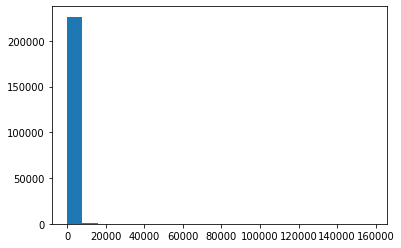

In [36]:
plt.hist(item_history_timespent, 20)

In [37]:
np.corrcoef(item_history_timespent, item_history_sizes)

array([[1.        , 0.79470717],
       [0.79470717, 1.        ]])

строгая корреляционная связь

# Strategy

item corpus -> generate candidates -> ranking -> select top 20

# Pipeline

In [38]:
VAL_SIZE = 0.2

In [39]:
VAL_N = int(len(df) * VAL_SIZE)

In [40]:
val = df[-VAL_N:].copy()

In [41]:
train = df[:-VAL_N]

In [42]:
user_id = 707536

In [43]:
len(train[train.user_id == user_id])

344

In [44]:
len(val[val.user_id == user_id])

5

In [45]:
np.mean(items.item_id == items.index)

1.0

In [46]:
train[train.user_id == user_id].item_id

0             67950
1            151002
2            134736
3            196151
4             94182
              ...  
104577217     27067
104577218     33975
111125829    210529
111125830      4726
111125960     34959
Name: item_id, Length: 344, dtype: int32

In [47]:
items.loc[[67950,151002 ]]

,item_id,source_id,embeddings
67950,67950,9868,"[-0.019559076, -0.016550511, -0.054519724, 0.0..."
151002,151002,13997,"[0.03910773, 0.0043324893, -0.02598767, -0.000..."


In [48]:
def get_embeddings(items_id):
    X = []
    for emb in items.loc[items_id].embeddings:
        v = np.array(emb)
        X.append(v)
    X = np.array(X)
    return X

In [49]:
embeddings = get_embeddings(train[train.user_id == user_id].item_id.values)

In [50]:
embeddings.shape

(344, 312)

In [51]:
sample = embeddings[0]

In [52]:
# эмбединги нормализованы, найс
np.allclose(np.ones(len(embeddings)), np.linalg.norm(embeddings, axis=1))

True

In [53]:
one_user_dot = np.dot(embeddings, sample)

(array([ 8., 18., 55., 95., 75., 53., 28., 10.,  1.,  1.]),
 array([0.44377634, 0.4993987 , 0.5550211 , 0.61064345, 0.66626585,
        0.72188824, 0.7775106 , 0.833133  , 0.8887554 , 0.9443777 ,
        1.0000001 ], dtype=float32),
 <a list of 10 Patch objects>)

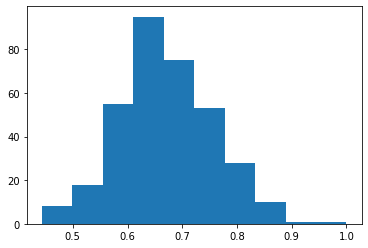

In [54]:
plt.hist(one_user_dot)

In [55]:
pd.Series(one_user_dot).describe()

count    344.000000
mean       0.671881
std        0.086725
min        0.443776
25%        0.614307
50%        0.664510
75%        0.727469
max        1.000000
dtype: float64

In [56]:
random_embeddings = get_embeddings(np.random.choice(items.item_id, len(embeddings)))

In [57]:
random_dot = np.dot(random_embeddings, sample)

(array([ 1.,  0.,  4., 22., 69., 87., 70., 53., 26., 12.]),
 array([0.3233499 , 0.37240237, 0.42145488, 0.47050735, 0.51955986,
        0.56861234, 0.6176648 , 0.6667173 , 0.7157698 , 0.7648223 ,
        0.8138748 ], dtype=float32),
 <a list of 10 Patch objects>)

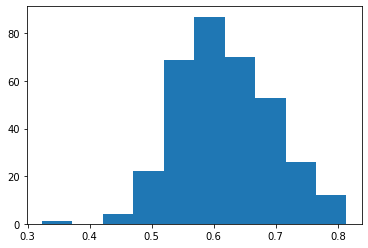

In [58]:
plt.hist(random_dot)

In [59]:
source_size = 99

In [60]:
item_sizes[item_sizes == source_size]

source_id
9125     99
10229    99
14784    99
18275    99
21442    99
23896    99
dtype: int64

In [61]:
source_id = item_sizes[item_sizes == source_size].index[0]
other_sources = item_sizes[item_sizes == source_size].index[1:]

In [62]:
one_source_embeddings = get_embeddings(items[items.source_id == source_id].item_id.values)

In [63]:
one_source_embeddings.shape

(99, 312)

In [64]:
source_sample = one_source_embeddings[0]

In [65]:
one_source_dot = np.dot(one_source_embeddings, source_sample)

(array([ 2.,  4., 12., 25., 25., 20.,  9.,  1.,  0.,  1.]),
 array([0.70086634, 0.7307797 , 0.7606931 , 0.7906065 , 0.82051986,
        0.85043323, 0.8803466 , 0.91025996, 0.9401734 , 0.97008675,
        1.0000001 ], dtype=float32),
 <a list of 10 Patch objects>)

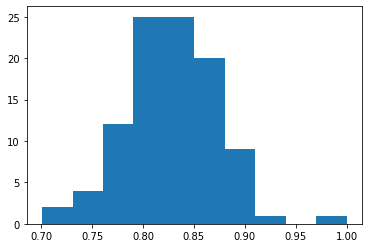

In [66]:
plt.hist(one_source_dot)

In [67]:
pd.Series(one_source_dot).describe()

count    99.000000
mean      0.828877
std       0.046697
min       0.700866
25%       0.803360
50%       0.830476
75%       0.855605
max       1.000000
dtype: float64

In [68]:
np.random.choice(other_sources)

21442

In [69]:
other_source_embeddings = get_embeddings(items[items.source_id == np.random.choice(other_sources)].item_id.values)

In [70]:
other_source_dot = np.dot(other_source_embeddings, source_sample)

(array([ 3.,  9., 28., 16.,  9., 10.,  7.,  7.,  6.,  4.]),
 array([0.523091  , 0.5580669 , 0.5930428 , 0.6280187 , 0.66299456,
        0.6979704 , 0.7329463 , 0.76792216, 0.80289805, 0.83787394,
        0.8728498 ], dtype=float32),
 <a list of 10 Patch objects>)

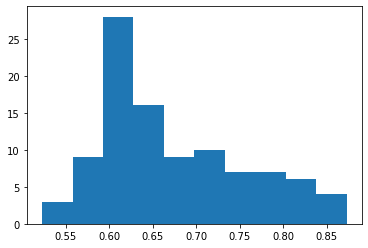

In [71]:
plt.hist(other_source_dot)

In [72]:
pd.Series(other_source_dot).describe()

count    99.000000
mean      0.673721
std       0.081727
min       0.523091
25%       0.611755
50%       0.647417
75%       0.730808
max       0.872850
dtype: float64

кластеризация по авторам намного лучше

есть авторы, пишушие рандом, к сожалению

In [73]:
all_embeddings = get_embeddings(items.item_id.values)

In [74]:
user_id

707536

In [75]:
subdf = train[train.user_id == user_id]

In [76]:
subdf.sort_values(by='timespent', ascending=0)

,user_id,item_id,timespent,reaction
38123543,707536,151165,9,0
72264300,707536,32641,8,0
57661199,707536,106614,6,0
38123545,707536,95324,6,0
48985485,707536,66374,5,0
...,...,...,...,...
22871552,707536,151379,0,0
22871551,707536,160475,0,0
22871550,707536,114484,0,0
22836798,707536,181946,0,0


In [77]:
train_label = train[train.user_id == user_id].sort_values(by='timespent', ascending=0)
train_label['rank'] = range(1, len(train_label)+1)
train_label = train_label[['user_id', 'item_id', 'rank']]

In [78]:
train_label.head(3)

,user_id,item_id,rank
38123543,707536,151165,1
72264300,707536,32641,2
57661199,707536,106614,3


In [79]:
train_embeddings = get_embeddings(train[train.user_id == user_id].item_id.values)

In [80]:
train_embeddings.shape

(344, 312)

In [81]:
val_embeddings = get_embeddings(val[val.user_id == user_id].item_id.values)

In [82]:
val_embeddings.shape

(5, 312)

In [83]:
center = np.average(train_embeddings, axis=0, weights=train[train.user_id == user_id].timespent.values)

In [84]:
center = np.average(train_embeddings, axis=0)

In [85]:
center.shape

(312,)

In [86]:
np.mean(np.dot(train_embeddings, center))

0.68258536

In [87]:
np.mean(np.dot(val_embeddings, center))

0.7135547

In [88]:
np.mean(np.dot(get_embeddings(val[val.user_id != user_id].item_id.unique()), center))

0.6521877

In [89]:
all_dot = np.dot(all_embeddings, center)

In [90]:
all_embeddings.shape

(227606, 312)

In [91]:
cur_item_df = pd.DataFrame()

In [92]:
cur_item_df['item_id'] = items.item_id.values

In [93]:
cur_item_df['sim'] = all_dot

In [94]:
cur_item_df.sim.describe()

count    227606.000000
mean          0.651878
std           0.047446
min           0.245687
25%           0.625809
50%           0.657882
75%           0.684721
max           0.768502
Name: sim, dtype: float64

In [95]:
cur_item_df.sort_values(by='sim', ascending=0)

,item_id,sim
140111,140111,0.768502
84005,84005,0.767932
557,557,0.767321
136322,136322,0.764874
165302,165302,0.764815
...,...,...
194580,194580,0.265414
35366,35366,0.262988
215621,215621,0.256919
26393,26393,0.250702


In [96]:
train_true_labels = train[train.user_id == user_id].item_id.values

In [97]:
# перцентиль 75% 
THRESH = 0.685

In [98]:
train_predict = cur_item_df[cur_item_df.sim > THRESH].sort_values(by='sim', ascending=0)[['item_id']]
train_predict['user_id'] = user_id

In [99]:
train_predict = train_predict[['user_id', 'item_id']]

In [100]:
train_predict['rank'] = range(1, len(train_predict)+1)

In [102]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    
    #print(result)
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [103]:
val[val.user_id == user_id].item_id.values

array([129681, 108734, 154113,  66080, 206309], dtype=int32)

# Evaluation

In [104]:
from sklearn.metrics import ndcg_score

In [105]:
# https://gist.github.com/bwhite/3726239
# Here's my small contribution; nDCG as defined by Kaggle: https://www.kaggle.com/wiki/NormalizedDiscountedCumulativeGain
# The only difference is: r → 2r - 1
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [106]:
test = pd.read_parquet('test.parquet.gzip')
test.head(3)

,user_id
0,7
1,8
2,9


In [107]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [108]:
knn = NearestNeighbors(metric='cosine')

In [109]:
all_embeddings = get_embeddings(items.item_id.values)

In [110]:
knn.fit(all_embeddings)

NearestNeighbors(metric='cosine')

In [111]:
vec = all_embeddings[0]

In [113]:
user_id

707536

In [114]:
user_embeddings = get_embeddings(df[df.user_id == user_id].item_id.values)

In [115]:
user_embeddings.shape

(349, 312)

In [119]:
user_id

707536

In [120]:
user_df = df[df.user_id == user_id].copy()

# get history
user_id_history = user_df.drop(['user_id'], 1)
user_embeddings = get_embeddings(user_id_history.item_id.values)

In [139]:
user_sources = items.loc[user_id_history.item_id].source_id.unique()

In [150]:
s = items.set_index('source_id').loc[user_sources].item_id.values

In [152]:
all_embeddings.shape

(227606, 312)

In [162]:
user_id_history

,item_id,timespent,reaction
0,67950,0,0
1,151002,0,0
2,134736,0,0
3,196151,0,0
4,94182,0,0
...,...,...,...
117610097,129681,0,0
118117191,108734,0,0
118117192,154113,0,0
118963368,66080,2,0


In [164]:
user_id_history.set_index('item_id').drop([67950, 151002])

,timespent,reaction
item_id,,
134736,0,0
196151,0,0
94182,0,0
175124,0,0
2551,0,0
...,...,...
129681,0,0
108734,0,0
154113,0,0


In [140]:
items.set_index('source_id')[user_sources]

KeyError: "None of [Int64Index([ 9868, 13997, 21610,  8813, 12122,  1672, 13052, 15850, 15958,\n            11551,\n            ...\n            14598,  3264, 16287,  3717,  9275,  4915, 23122, 16916, 18660,\n             4291],\n           dtype='int64', length=192)] are in the [columns]"

In [123]:
user_id_history.shape

(349, 3)

In [121]:
len(all_embeddings)

227606

In [305]:
class SourceCluster:
    def __init__(self, top_n, thresh, use_weights=False):
        self.top_n = top_n
        self.thresh = thresh
        self.use_weights = use_weights
    
    def fit(self, candidates):
        self.embeddings = get_embeddings(candidates.item_id.values)
        self.candidates = candidates
    
    def predict(self, user_id, user_df):
#         user_df = df[df.user_id == user_id].copy()
        
        # get history
        user_embeddings = get_embeddings(user_df.item_id.values)
        
        # select favorites sources 
        user_id_sources = items.loc[user_df.item_id].source_id.unique()
        
        weights = None
        if self.use_weights:
            weights = (user_df.timespent.values * TIMESPENT_COEF).astype(float)
            weights += (user_df.reaction.values - user_df.reaction.mean()) * REACTION_COEF
            
        # calc center vector and dists
        center = np.average(user_embeddings, axis=0, weights=weights)        
        
        # form candidates
        candidates = pd.DataFrame(columns=['item_id', 'sim'])
        candidates['item_id'] = items.set_index('source_id').loc[user_sources].item_id.values
        
        
        embeddings = get_embeddings(candidates['item_id'].values)
        
        candidates['sim'] = np.dot(embeddings, center)
        
        
        candidates = candidates[candidates.sim > self.thresh]
        stay_item_ids = [i for i in candidates.item_id if i not in user_id_history.item_id]
        
        candidates = candidates.set_index('item_id').loc[stay_item_ids]
        candidates = candidates.sort_values(by='sim', ascending=False)
        
        return candidates.head(self.top_n).index.values
        
    
    def rerank(self, user_df, candidates):
        return candidates.head(self.top_n).index.values

In [295]:
len(df.user_id.unique())

1000183

In [317]:
# train упорядочен хронологически
df = pd.read_parquet('train.parquet.gzip')
df.dtypes

user_id      int32
item_id      int32
timespent     int8
reaction      int8
dtype: object

In [299]:
for user_id, subdf in tqdm(df.groupby('user_id'), total=len(df.user_id.unique())):
    pass

100%|██████████| 1000183/1000183 [00:28<00:00, 35401.84it/s]


In [318]:
testset = set(test.user_id)

In [319]:
model = SourceCluster(top_n=20, thresh=0.6, use_weights=True)
model.fit(candidates)

In [ ]:
predictions = []
for user_id, subdf in tqdm(df.groupby('user_id'), total=len(df.user_id.unique())):
    if user_id in testset:
        pred = model.predict(user_id, subdf)
        predictions.append((user_id, pred))

 66%|██████▌   | 659873/1000183 [3:03:30<1:14:07, 76.52it/s] 

In [261]:
self = SourceCluster(top_n=20, thresh=0.6, use_weights=True)

In [262]:
%%timeit
self.fit(candidates)

KeyboardInterrupt: 

In [ ]:
%%timeit
self.fit(candidates.head(1000))

In [ ]:
(116 * len(test)) / 1000 / 60 / 60

In [ ]:
user_df = df[df.user_id == user_id].copy()

In [266]:
model = SourceCluster(top_n=20, thresh=0.6, use_weights=True)

In [267]:
model.fit(candidates)

In [268]:
predictions = []
for user_id in tqdm(test.user_id):
    
#     predictions.append(model.predict(user_id))

  0%|          | 31/200000 [00:04<8:48:36,  6.30it/s]


KeyboardInterrupt: 

In [218]:
predictions

[array([100501, 205787,   8451,  79598, 101907,   7286,  13292, 156811,
         42399, 181994,  45561,  67330,  21996, 210682, 133163,  38227,
         84525, 202188, 111489, 101739]),
 array([ 67841,  18298, 151379, 157068, 122771, 154119, 201697,  78688,
        168640,   8642, 170654,  17921, 178547,    228, 109671, 162455,
        159427,  38908, 124115, 212966]),
 array([100451, 226737, 120283,  11590, 160698,  40639,  46767, 126336,
         82335,  20126,   7248,  13705, 178023,  61120, 157095,  31460,
        208843, 144769, 176985,  69070]),
 array([ 56750,  11658, 202806,  72642, 149371,  81377, 176823,  36653,
         34619, 197315,  75834,   8132,  28668, 138297,  12507, 158378,
         60511, 120351, 158909, 215913]),
 array([ 13292, 166942, 204521,   4886, 162467, 101907, 205787, 112563,
        139390,   8451,  57009,  86895, 176336,   7286,   8880,  59587,
         40116, 100637, 188816, 100501]),
 array([202963,  94952, 180244, 184983,  74082, 111697, 162376, 116625

In [374]:
center.shape

(312,)

In [379]:
two_centers = np.stack([center, center], axis=1)

In [380]:
two_centers.shape

(312, 2)

In [382]:
np.dot(all_embeddings, two_centers).shape

(227606, 2)

In [ ]:
test['predictions'] = predictions
test

In [ ]:
test.to_parquet('sample_submission.parquet.gzip', compression='gzip', engine='pyarrow')